In [29]:
import os;
import sys;
import random;
import json

import numpy as np;
import cv2;
import matplotlib.pyplot as plt;

import tensorflow as tf
from tensorflow import keras;
import openslide
import imutils
import pylab

In [30]:
class DataLoader(keras.utils.Sequence):
    def __init__(self,ids,batch_size=0,image_size=(256,256),aug=False):
        self.ids=ids;
        self.aug = aug;
        self.batch_size =batch_size;
        self.image_size = image_size;
        
        
    def __load__(self,id_name):
        
        path="/home/ubuntu/data/gland_public/";
        
        image_path = os.path.join(path,id_name)+".bmp";
        
        image = cv2.imread(image_path);
        
        if self.aug==True:
            
            n = random.choice([0,1]);
            
            if n ==0:
                source = openslide.open_slide(image_path);
                dimensions = source.dimensions

                image =source.read_region( (0,0),0,(dimensions[0],dimensions[1]));
                image =  np.array( image );

                image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB);  
            
            n = random.choice([0,1]);
            if n==0:
                image =  cv2.normalize(image, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
            
            
            n = random.choice([0,1,3,5]);
            if n !=0:
                image = cv2.GaussianBlur(image,(n,n),cv2.BORDER_DEFAULT)
            
            n = random.choice([1,1.25,1.5,1.75,2]);
            shape = image.shape
            
            shapeY = int(shape[0]/n)
            shapeX = int(shape[1]/n)
            image = cv2.resize(image,(shapeX,shapeY))
        
        
        
        else:
            image =  cv2.normalize(image, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
        
        
        mask_path= os.path.join(path,id_name)+"_anno.bmp";
        mask = cv2.imread(mask_path,-1);
        
        n = random.choice([0,90,180,270]);
        if n !=0 and self.aug==True:
            image = imutils.rotate(image, n);
            mask = imutils.rotate(mask, n);
        
        
        
        image = cv2.resize(image,self.image_size);
        
        
        
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY);
        
        deep=cv2.CV_64F;
        x=cv2.Sobel(gray,deep,1,0)
        y=cv2.Sobel(gray,deep,0,1)

        absx= cv2.convertScaleAbs(x)
        absy= cv2.convertScaleAbs(y)

        dist = cv2.addWeighted(absx,0.5,absy,0.5,0)
    
        lap = cv2.Laplacian(gray,deep,3)
        lap = cv2.convertScaleAbs(lap);
        
        
        newimg = np.zeros(self.image_size+(5,))
        
        newimg[:,:,:3] = image;
        newimg[:,:,3] = dist;
        newimg[:,:,4] = lap;
        
        image= newimg;
        
        
        thresh =0.5
        mask = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1]
        mask=cv2.resize(mask,self.image_size);
        mask = np.expand_dims(mask,axis=-1);
        mask =np.maximum(mask,mask);
        
        
        image =image/255.0;
        mask = mask/255.0;
        
        return image, mask;
    
    def __getitem__(self,index):
        if (index+1)*self.batch_size >len(self.ids):
            self.bach_size=len(self.ids)-index*batch_size;
            
        files_batch = self.ids[index*self.batch_size:(index+1)*self.batch_size]
        
        image=[];
        mask=[];
        
        for id_name in files_batch:
            _img,_mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask);
        
        image =np.array(image)
        mask =np.array(mask);
        
        return image, mask;
    
    def on_epoch_end(self):
        pass;
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)));


In [3]:
image_size = (512,512);
batch_size = 10

In [4]:
path="/home/ubuntu/data/gland_public/";

train_ids=[];
test_ids=[];
test_ids2=[];

files=os.listdir(path)
for i in files:
    i = i.replace("_anno.bmp","").replace(".bmp","");
    if i.startswith("testB"):
        test_ids2.append(i)
        
    elif i.startswith("train"):
        train_ids.append(i)
        
    elif i.startswith("testA"):
        test_ids.append(i)
        

train_ids=list(set(train_ids))
test_ids=list(set(test_ids))
test_ids2=list(set(test_ids2))




print(len(train_ids))
print(len(test_ids))
print(len(test_ids2))

85
60
20


In [39]:
test_data = DataLoader(test_ids,batch_size=batch_size,image_size = image_size)
test_data2 = DataLoader(test_ids2,batch_size=batch_size,image_size = image_size)

(10, 512, 512, 5) (10, 512, 512, 1)
6


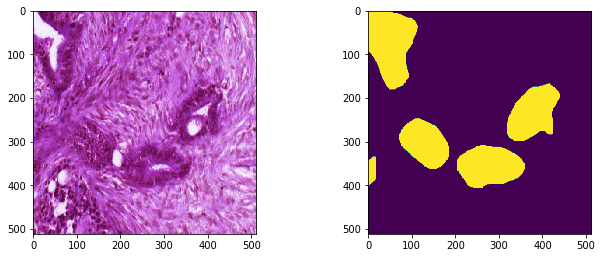

In [7]:

x,y = test_data.__getitem__(1)

print(x.shape,y.shape)

r=random.randint(0,len(x)-1);
print(r)
fig = plt.figure(figsize=(10,10));
fig.subplots_adjust(hspace=0.5,wspace=0.5)
ax = fig.add_subplot(1,2,1)
ax.imshow(x[r][:,:,:3])
ax = fig.add_subplot(1,2,2)
ax.imshow(np.reshape(y[r],image_size))

In [8]:
#vgg unet
def down_block(x,filters,kernel_size=(3,3),padding="same",strides=1):
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(x);
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(c);
    p = keras.layers.MaxPool2D((2,2),(2,2))(c);
    
    return c,p

def up_block(x,skip,filters,kernel_size=(3,3),padding="same",strides=1):
    us=keras.layers.UpSampling2D((2,2))(x);
    concat = keras.layers.Concatenate()([us,skip])
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(concat);
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(concat);
    return c;


def bottleneck(x,filters,kernel_size=(3,3),padding="same",strides=1):
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(x);
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(c);
    return c;

In [9]:
def UNet():
    f = [16,32,64,128,256,512];
    
    inputs = keras.layers.Input(image_size+(5,))
    
    p0=inputs;
    c1,p1 = down_block(p0,f[0])  
    c2,p2 = down_block(p1,f[1]) 
    c3,p3 = down_block(p2,f[2])
    c4,p4 = down_block(p3,f[3]) 
    c5,p5 = down_block(p4,f[4])
    
    bn = bottleneck(p5,f[5])
    
    u5= up_block(bn,c5,f[4])
    u4= up_block(u5,c4,f[3])  
    u3= up_block(u4,c3,f[2])
    u2= up_block(u3,c2,f[1])
    u1= up_block(u2,c1,f[0])
    
    outputs = keras.layers.Conv2D(1,(1,1),padding="same",activation='sigmoid')(u1);
    model = keras.models.Model(inputs,outputs)
    
    return model

In [13]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Using TensorFlow backend.


In [53]:
smooth=1;

def dice_coef(y_true,y_pred):
    y_true_f = keras.layers.Flatten()(y_true)
    y_pred_f = keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f* y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f)+tf.reduce_sum(y_pred_f)+ smooth )
    
def dice_coef_loss(y_true,y_pred):
    return 1.0- dice_coef(y_true,y_pred)

In [ ]:
model = UNet();

In [61]:

model.compile(optimizer = "adam",loss="binary_crossentropy",metrics=['acc',f1_m,precision_m, recall_m,dice_coef]);
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 5) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 736         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [66]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('model3_5channel_check.hdf5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')


In [34]:
for i in range(30):
    valids= random.sample(train_ids,15);
    traids= [x for x in train_ids if x not in valids];
    train_data = DataLoader(traids,batch_size=batch_size,image_size = image_size,aug=True)
    valid_data = DataLoader(valids,batch_size=batch_size,image_size = image_size,aug=True)
    
    train_steps= len(traids)//batch_size;
    valid_steps= len(valids)//batch_size;
    
    epochs = 40;
    model.load_weights("model3_5channel_check.hdf5")
    result = model.fit_generator(train_data, validation_data=valid_data, 
                                 steps_per_epoch=train_steps, 
                                 validation_steps=valid_steps, 
                                epochs=epochs,callbacks=[checkpoint])
    

Epoch 1/50
6/7 [========================>.....] - ETA: 15s - loss: 0.1189 - acc: 0.9462 - f1_m: 0.9429 - precision_m: 0.9448 - recall_m: 0.9413
Epoch 00001: val_loss improved from 0.11118 to 0.10278, saving model to model3_5channel_check.hdf5
7/7 [==============================] - 111s 16s/step - loss: 0.1161 - acc: 0.9470 - f1_m: 0.9434 - precision_m: 0.9443 - recall_m: 0.9428 - val_loss: 0.1028 - val_acc: 0.9523 - val_f1_m: 0.9451 - val_precision_m: 0.9580 - val_recall_m: 0.9325
Epoch 2/50
6/7 [========================>.....] - ETA: 15s - loss: 0.1051 - acc: 0.9501 - f1_m: 0.9481 - precision_m: 0.9508 - recall_m: 0.9456
Epoch 00002: val_loss did not improve from 0.10278
7/7 [==============================] - 111s 16s/step - loss: 0.1153 - acc: 0.9478 - f1_m: 0.9458 - precision_m: 0.9501 - recall_m: 0.9417 - val_loss: 0.1108 - val_acc: 0.9495 - val_f1_m: 0.9426 - val_precision_m: 0.9493 - val_recall_m: 0.9360
Epoch 3/50
6/7 [========================>.....] - ETA: 15s - loss: 0.1052 - 